In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings("ignore")

In [11]:
# Getting the data
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df.head()

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,1,0,1617,0,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0


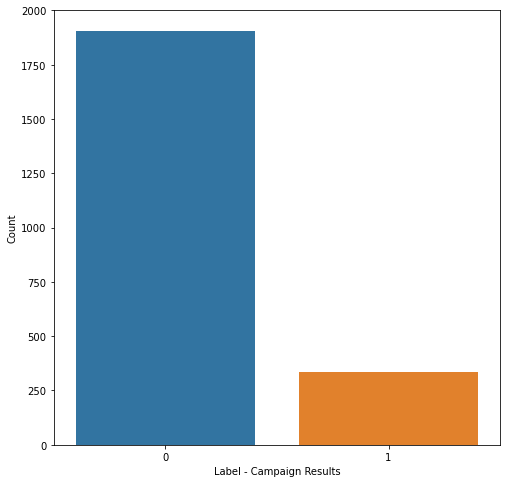

In [12]:
# Distribution of the labels in the dataset
plt.rcParams["figure.figsize"] = (8, 8)
sns.countplot(customer_data_df["Response"])
plt.grid(False)
plt.xlabel("Label - Campaign Results")
plt.ylabel("Count")
plt.show()

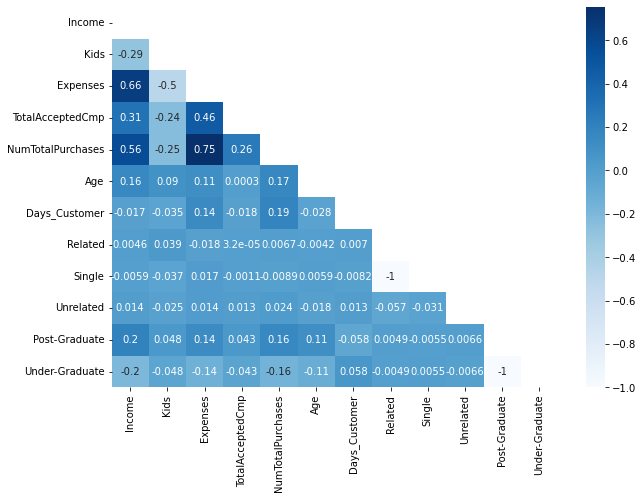

In [29]:
# plot correlation matrix
corr = customer_data_df.drop("Response", axis =1).corr()
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))
#corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot = True, cmap="Blues")
plt.show()

In [22]:
# Splitting the dataset
data_X = customer_data_df.drop(columns=['Response'])
data_y = customer_data_df['Response']
print(data_X.columns)

Index(['Income', 'Kids', 'Expenses', 'TotalAcceptedCmp', 'NumTotalPurchases',
       'Age', 'Days_Customer', 'Related', 'Single', 'Unrelated',
       'Post-Graduate', 'Under-Graduate'],
      dtype='object')


In [27]:
# Pre-Processing the data

# Split the dataset into training (80%), validation (20%), and test (20%) sets
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X,data_y, train_size=0.8,random_state=10)

# Standardize the columns in the feature matrices
ss = StandardScaler()
data_X_train = ss.fit_transform(data_X_train)
data_X_test = ss.transform(data_X_test)

# Add a column of ones to the feature matrices of train, validation and test dataset
data_X_train = (np.column_stack((np.ones(len(data_X_train)),data_X_train)))
data_X_test = (np.column_stack((np.ones(len(data_X_test)),data_X_test)))

In [54]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression(solver = 'liblinear')
logi.fit(data_X_train, data_y_train)

y_pred = logi.predict(data_X_test)

print(f"Accuracy Score for Dev Data: {logi.score(data_X_train, data_y_train) * 100}")
print(f"Accuracy Score for Testing Data: {logi.score(data_X_test, data_y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(data_y_test, y_pred)}")

Accuracy Score for Dev Data: 88.39285714285714
Accuracy Score for Testing Data: 87.5
F-1 Score for Testing Data: 0.40425531914893625


In [100]:
param_grid = {
    'tol': [1e-5, 1e-4, 1e-3, 0.1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty':  ['none', 'l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3,3,7)
}

pipe = make_pipeline(GridSearchCV(LogisticRegression(),param_grid = param_grid, \
                                  cv = 5, \
                                  return_train_score = True))

pipe.fit(data_X_train, data_y_train)

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_tol = grid_search_results.best_params_['tol']
grid_search_result_penalty = grid_search_results.best_params_['penalty']
grid_search_result_solver = grid_search_results.best_params_['solver']
grid_search_result_C = grid_search_results.best_params_['C']

print(f"Best value of hyperparameter tol is: {grid_search_result_tol}")
print(f"Best penalty is: {grid_search_result_penalty}")
print(f"Best solver is: {grid_search_result_solver}")
print(f"Best value of hyperparameter C is: {grid_search_result_C}")
print(f"F-1 Score for Testing Data: {pipe.score(data_X_test, data_y_test)}")

Best value of hyperparameter tol is: 0.1
Best penalty is: none
Best solver is: sag
Best value of hyperparameter C is: 0.01
F-1 Score for Testing Data: 0.8705357142857143


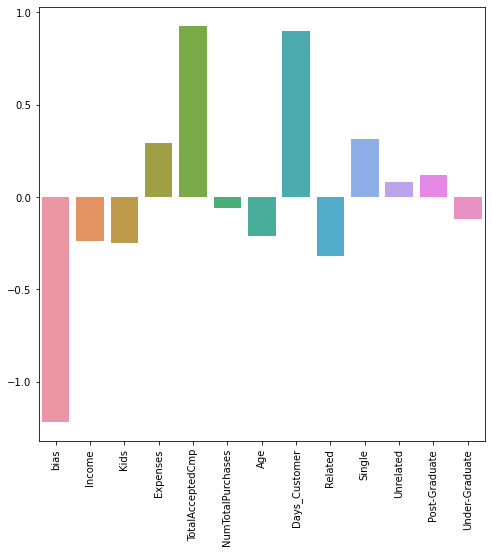

In [106]:
logi_best = LogisticRegression(C = grid_search_result_C, 
                               penalty = grid_search_result_penalty,
                               solver = grid_search_result_solver, 
                               tol = grid_search_result_tol)
logi_best.fit(data_X_train, data_y_train)
y_pred_best = logi_best.predict(data_X_test)

col_names = data_X.columns.tolist()
col_names.insert(0,'bias')
sns.barplot(col_names, logi_best.coef_[0])
plt.xticks(rotation=90)
plt.show()

In [107]:
print(f"Accuracy Score for Dev Data: {logi_best.score(data_X_train, data_y_train) * 100}")
print(f"Accuracy Score for Testing Data: {logi_best.score(data_X_test, data_y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(data_y_test, y_pred_best)}")

Accuracy Score for Dev Data: 88.02083333333334
Accuracy Score for Testing Data: 86.60714285714286
F-1 Score for Testing Data: 0.39999999999999997


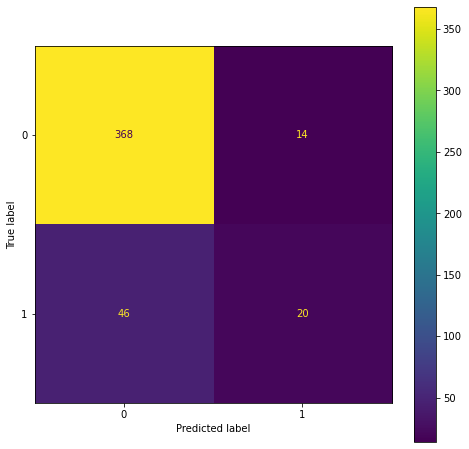

In [111]:
plot_confusion_matrix(logi_best, data_X_test, data_y_test)
plt.show()